In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
meas = Base.classes.measurement
stat = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

In [10]:
session.query(func.count(meas.date)).all() # returns total number of dates

[(19550)]

In [11]:
session.query(meas.date).order_by(meas.date.desc()).first() # returns most recent date

('2017-08-23')

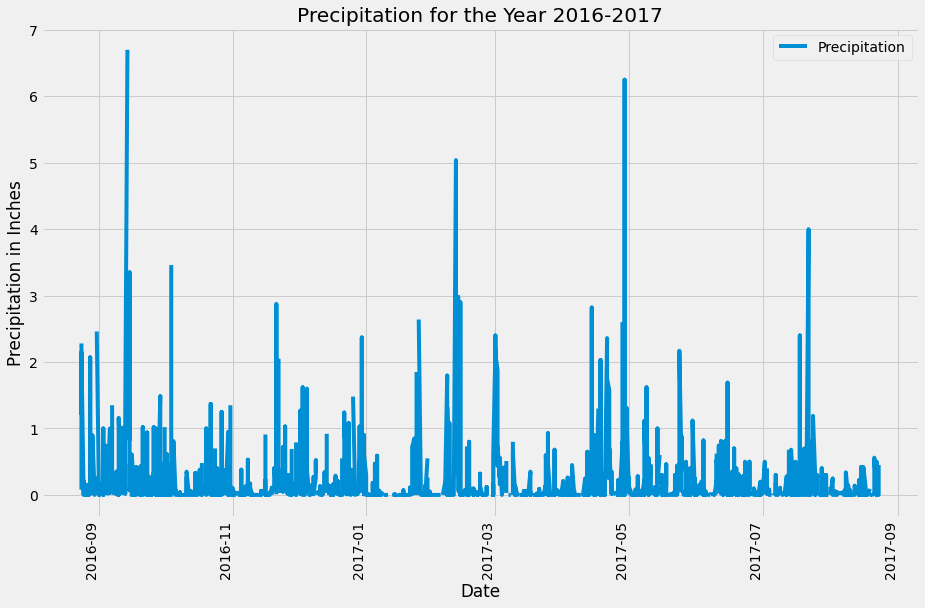

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
recent_date = session.query(meas.date).order_by(meas.date.desc()).first() 

# put recent_date into date format
last_date = dt.datetime.strptime(recent_date.date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
meas_data = session.query(meas.date, meas.station, meas.prcp, meas.tobs).filter(meas.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
meas_df = pd.DataFrame(meas_data)
meas_df = meas_df[['date', 'prcp']]
meas_df.rename(columns = {'date':'Date', 'prcp':'Precipitation'}, inplace = True)
meas_df['Date'] = pd.to_datetime(meas_df['Date'], format='%Y-%m-%d')
meas_df.set_index('Date', inplace=True)

# Sort the dataframe by date

sorted_meas_df = meas_df.sort_index(ascending=False)
sorted_meas_df

# Use Pandas Plotting with Matplotlib to plot the data
sorted_meas_df.plot(rot=90, figsize=(14,10))
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")
plt.title("Precipitation for the Year 2016-2017")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sum_stats = sorted_meas_df.describe()
prcp_sum_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(stat.station)).all()

[(9)]

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_list = [meas.station, func.count(meas.station)] # station name, count of how many times this station appears

active_stations = session.query(*station_list).group_by(meas.station).order_by(func.count(meas.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
most_active_station = session.query(*station_list).group_by(meas.station).order_by(func.count(meas.station).desc())\
                        .first().station
print(f'The most active station is {most_active_station}.')


The most active station is USC00519281.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# func.min, func.max, func.avg
sel_temps = [meas.station, 
       func.min(meas.tobs),
       func.max(meas.tobs),
       func.avg(meas.tobs)]

active_temps = session.query(*sel_temps).group_by(meas.station).order_by(func.count(meas.station).desc()).all()

most_active_stat_temps = session.query(*sel_temps).group_by(meas.station).order_by(func.count(meas.station).desc()).first()


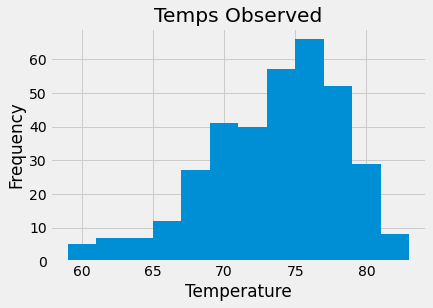

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(meas.station, meas.tobs)\
            .filter((meas.date > year_ago) & (meas.station == most_active_station)).all()
tobs_df = pd.DataFrame(tobs_data)
tobs_df = tobs_df.rename(columns = {'station':'Station', 'tobs':'Temps Observed'})

tobs_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [19]:
# Close Session
session.close()